# July 17th, 2018
## Benjamin Adam Catching
## Andino Lab, Summer Rotation
## Polio DIPs Project

In [56]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import skimage.io
import skimage.measure
import skimage.color
import scipy.ndimage
import skimage.measure
import skimage.feature
import skimage.segmentation
%matplotlib inline
plt.interactive(False)

In [2]:
# Set the image directory based on if working on notebook in pycharm or not
in_pycharm = True
if in_pycharm:
    bulk_cell_dir = 'data/20180710_Microfluidic_picture/'
else:
    bulk_cell_dir = '../../data/20180710_Microfluidic_picture/'
    
# Define the six directories that contain image files
hs_files = 'HeLa_Slow/*40X*.tif'
hf_files = 'HeLa_Fast/*40X*.tif'
hsr_files = 'HeLa_Slow_Rock/*40X*.tif'
hfr_files = 'HeLa_Fast_Rock/*40X*.tif'
two93f_files = '293T_Fast/*40X*.tif'
two93s_files = '293T_Slow/*40X*.tif'

In [3]:
# Read in the HeLa cell files and sort
HeLa_Slow_files = sorted(glob.glob(bulk_cell_dir + hs_files))
HeLa_Slow_Rock_files = sorted(glob.glob(bulk_cell_dir + hsr_files))
HeLa_Fast_files = sorted(glob.glob(bulk_cell_dir + hf_files))
HeLa_Fast_Rock_files = sorted(glob.glob(bulk_cell_dir + hfr_files))

In [4]:
# Look at a test list of files
print([len(x) for x in [HeLa_Fast_files,
                        HeLa_Fast_Rock_files,
                        HeLa_Slow_files,
                        HeLa_Slow_Rock_files]])

[20, 6, 2, 2]


In [5]:
# Test the import of the microfluidics analysis script
from tools import microfluidics_analysis as micro

In [6]:
# Segment a droplet image
test_droplet_image = micro.BulkDroplet(HeLa_Fast_files[0], multi_channel=True)

The file is updated


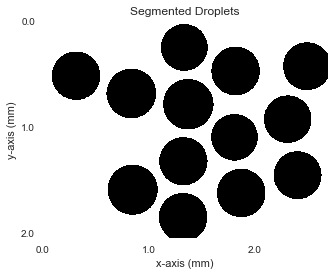

In [9]:
test_droplet_labeled, test_droplet_props = \
    test_droplet_image.droplet_segment(testing=True)

In [49]:
def cell_bright_gfp_thresh(droplet_label, 
                           droplet_props, 
                           bright_file, 
                           gfp_file,
                           gfp_thresh=50):
    """
    Use the threshold droplet labels and properties in combination with
    the brightfield and GFP image to return output of segmented cell and
    segmented dead cells.
    
    Parameters
    ----------
    droplet_label:
        numpy array where each droplet's region is a number (i.g. 1, 2, 3...)
    droplet_props:
        list of skimage.measure.properties values about droplets
    bright_file:
        filename of the brightfield microscopy image 
        (same dimensions of droplet_label and gfp_file)
    gfp_file:
        filename of the gfp microscopy image
        (same dimensions of droplet_label and bright_file)
    gfp_thresh:
        the threshold of the gfp
        
    Returns
    -------
    droplet_cells_list:
        list of black-white images of segmented cells
    droplet_gfp:
        list of black-white numpy images for gf
    """
    
    # Test images (brightfield and GFP)
    test_raw_image = skimage.io.imread(bright_file)[:, :, 0]
    test_gfp_image = skimage.io.imread(gfp_file)[:, :, 1]
    
    # Actual droplet segmented GFP image properties
    gfp_droplet_props = skimage.measure.regionprops(droplet_label, 
                                                    test_gfp_image)
    
    # Create list of Segmented GFP droplet images
    droplet_gfp = []
    for index, prop in enumerate(gfp_droplet_props):
        droplet_gfp.append(prop.intensity_image > gfp_thresh)
         
    # Create list of brightfield cells
    droplet_cells_list = []
    for i in range(len(droplet_props)):
        droplet_cells_list.append(micro.cells_from_droplet(droplet_label,
                                                           test_raw_image, 
                                                           i))
        
    return droplet_cells_list, droplet_gfp

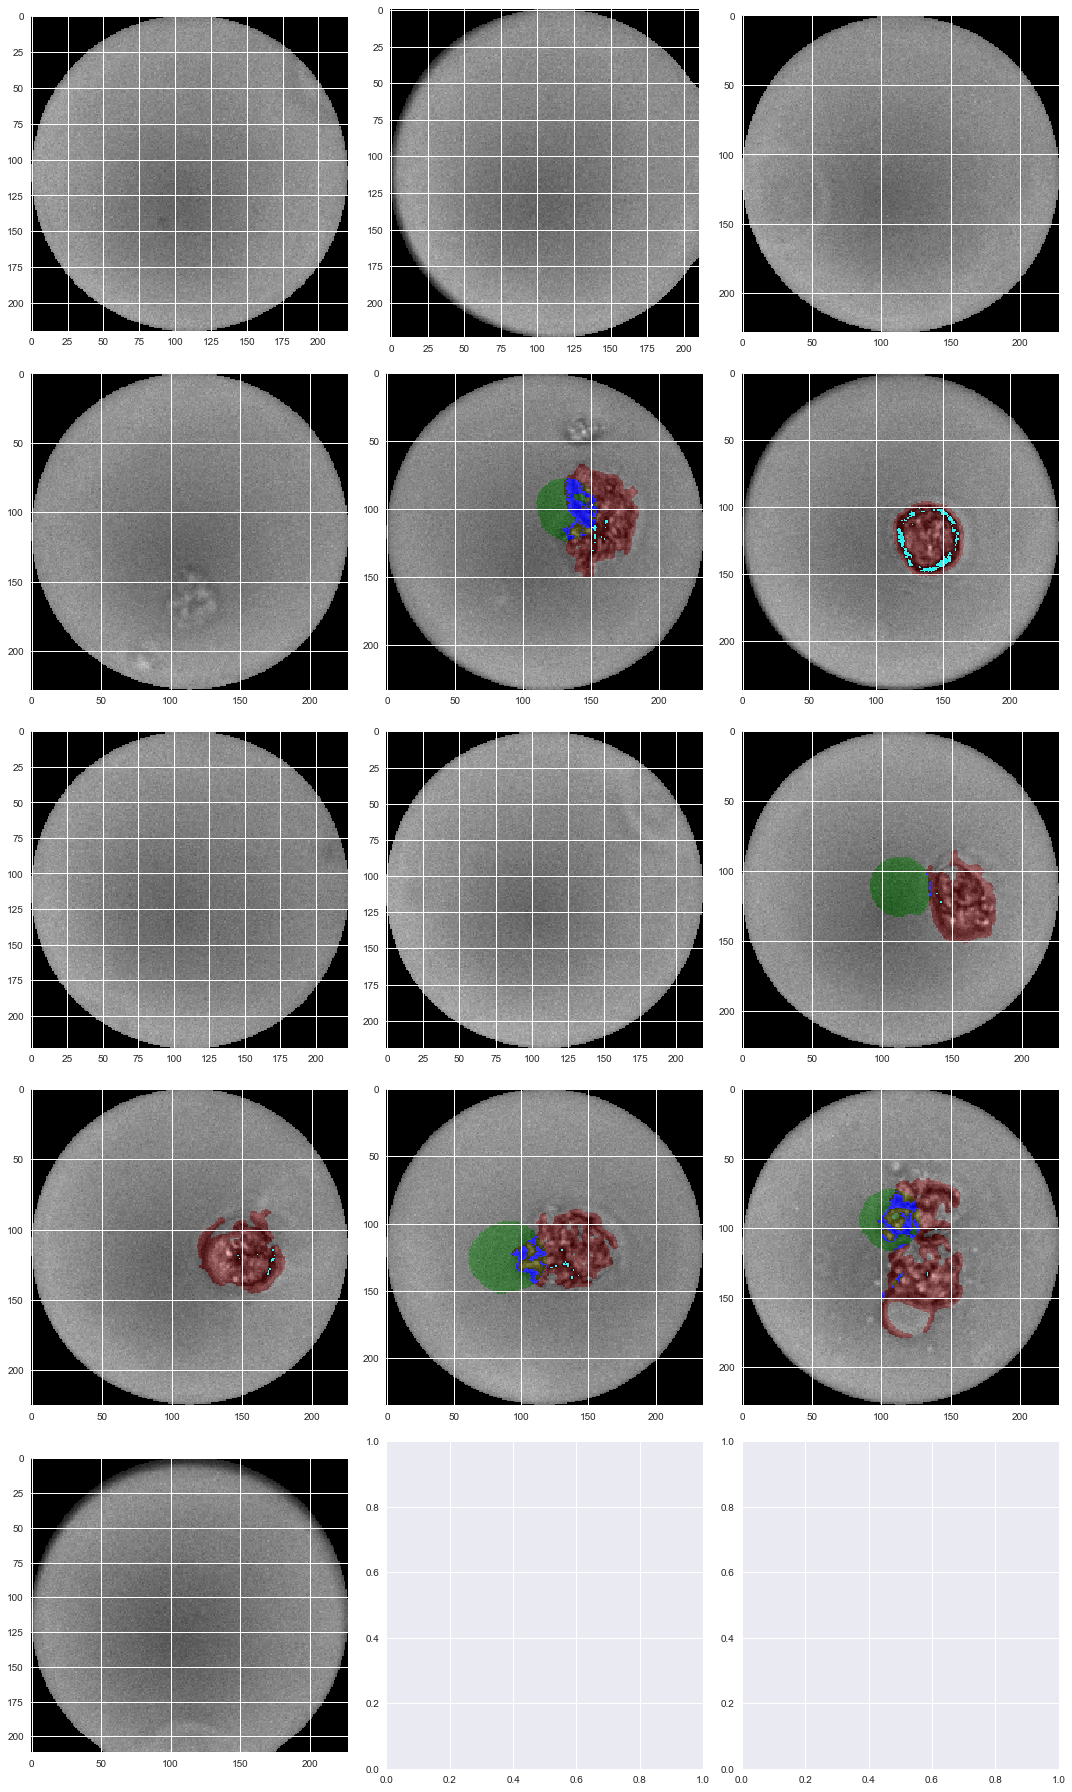

In [48]:
# Look at the two overlapping images
droplet_cells_list, gfp_droplets = cell_bright_gfp_thresh(test_droplet_labeled, 
                                                          test_droplet_props,
                                                          HeLa_Fast_files[0],
                                                          HeLa_Fast_files[1])

num_rows = (len(droplet_cells_list) // 3) + 1
fig, ax = plt.subplots(num_rows, 3, figsize=(15, 25))
for i in range(num_rows):
    for j in range(3):
        num = i * 3 + j
        try:
            temp_rgb = skimage.color.grey2rgb(test_droplet_props[num].intensity_image)
            temp_rgb[:, :, 1] = temp_rgb[:, :, 1] + droplet_cells_list[num] * 200
            temp_rgb[:, :, 2] = temp_rgb[:, :, 2] + droplet_cells_list[num] * 200
            temp_rgb[:, :, 0] = temp_rgb[:, :, 0] + (gfp_droplets[num]) * 200
            temp_rgb[:, :, 2] = temp_rgb[:, :, 2] + (gfp_droplets[num]) * 200
            ax[i, j].imshow(temp_rgb)
        except:
            break
plt.tight_layout()
plt.show()

In [84]:
def diff_cells(bw_cells):
    """
    Some cells may be connected and treated as a single cell, use the watershed
    algorithm and the watershed algorithm to return labeled cells with their 
    properties. 
    
    Reference:
    scipy-lectures.org/packages/scikit-image/auto_examples/plot_segmentations
    
    Parameters
    ----------
    bw_cells:
        binary numpy image that contains cells
    
    Return
    ------
    cell_labels:
        numpy array image where each cell region is assigned a different number
    cell_props:
        list of properties of the cell areas
    """
    
    # Generate the markers as local maximum of the distance to the background
    distance = scipy.ndimage.distance_transform_edt(bw_cells)
    local_maxi = skimage.feature.peak_local_max(distance, 
                                                indices=False, 
                                                footprint=np.ones((50, 50)), 
                                                labels=bw_cells)
    markers = skimage.measure.label(local_maxi)
    
    # Label the cells from the centers of the local max
    cell_labels = skimage.segmentation.watershed(-bw_cells, markers, mask=bw_cells)
    
    # Return the properties of these cells
    cell_props = skimage.measure.regionprops(cell_labels)
    
    return cell_labels, cell_props

In [85]:
seg_cells_labels, seg_cells_props = diff_cells(droplet_cells_list[11])

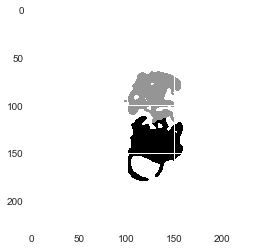

In [86]:
# Show result applied to a droplet with two cells
plt.imshow(seg_cells_labels)
plt.show()

In [87]:
# Return the number of cells
len(seg_cells_props)

2